# Суть работы:

1. Используя генетический алгоритм протестировать несколько моделей на одном аборе данных.
2. Реализовать обучение с подкреплением, используя генетический алгоритм.
3. Попытка переноса весов с одной среды в другую.

# Импорт и установка

In [ ]:
from keras.datasets.mnist import load_data # Скачивание датасета
from numpy import expand_dims
from sklearn.model_selection import train_test_split # Разделение на выборки
import random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical

# Подготовка датасета


In [ ]:
def prepare_data_for_dense():
    # Загрузка данных
    (X, y), (_, _) = load_data()

    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # разделяем данные на обучающую и тестовую выборки (20% тестовых данных)

    image_size = X_train.shape[1]
    input_size = image_size * image_size

    X_train = np.reshape(X_train, [-1, input_size])
    X_test = np.reshape(X_test, [-1, input_size])

    # Номирование тензоров
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255


    y_train = to_categorical(y_train, 10) # Кодируем обучающие метки на 10 классов
    y_test = to_categorical(y_test, 10)   # Кодируем тестовые метки на 10 классов
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = prepare_data_for_dense()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


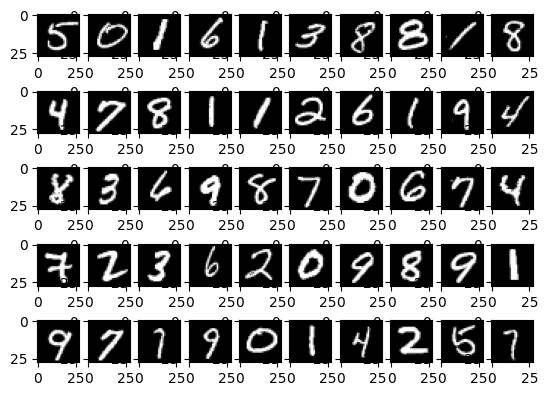

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(50):

    x = X_train[i]
    x = x.reshape((28, 28))
    im = plt.subplot(5, 10, i+1)
    im.imshow(x, cmap='gray')

# Генетический алгоритм на MNIST № 1


In [ ]:
# Запуск генетического алгоритма
population_size = 6  # размер популяции
num_generations = 4  # количество поколений
mutation_rate = 0.1  # вероятность мутации

In [ ]:
# Функция приспособленности
def fitness_function(params):
    learning_rate, num_layers, num_neurons = params  # извлекаем гиперпараметры из входных параметров

    model = Sequential()  # создаем модель нейронной сети
    model.add(Input(shape=(X_train.shape[1],)))  # добавляем Input слой с указанием формы входных данных
    model.add(Dense(num_neurons, activation='relu'))  # добавляем первый слой с указанным количеством нейронов и ReLU активацией
    for _ in range(num_layers - 1):  # добавляем дополнительные скрытые слои
        model.add(Dense(num_neurons, activation='relu'))
    model.add(Dense(10, activation='sigmoid'))  # добавляем выходной слой с 10 нейронами и softmax активацией

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # компилируем модель с оптимизатором Adam и функцией потерь для многоклассовой классификации
    model.fit(X_train, y_train, epochs=5, verbose=0)  # обучаем модель на обучающих данных

    test_loss, test_acc = model.evaluate(X_test, y_test) # вычисляем потерю и тоность
    return test_acc  # возвращаем точность как значение приспособленности

In [ ]:
def crossover(parent1, parent2):
    child1 = (parent1[0], parent2[1], parent1[2])  # создаем первого потомка путем обмена параметрами между родителями
    child2 = (parent2[0], parent1[1], parent2[2])  # создаем второго потомка путем обмена параметрами между родителями
    return child1, child2  # возвращаем потомков

In [ ]:
def mutate(individual, mutation_rate):
    if random.random() < mutation_rate:  # проверяем вероятность мутации
        individual = (random.uniform(0.001, 0.1), random.randint(1, 5), random.randint(10, 100))  # мутируем особь
    return individual  # возвращаем мутировавшую особь

In [ ]:
# Генетический алгоритм
def genetic_algorithm_for_dense(population_size, num_generations, mutation_rate):
    population = []  # инициализируем популяцию
    for _ in range(population_size):  # создаем начальную популяцию
        learning_rate = random.uniform(0.001, 0.1)  # случайно выбираем learning rate
        num_layers = random.randint(1, 3)  # случайно выбираем количество слоев
        num_neurons = random.randint(10, 100)  # случайно выбираем количество нейронов
        population.append((learning_rate, num_layers, num_neurons))  # добавляем особь в популяцию

    best_fitness = 0
    best_individual = None

    for generation in range(num_generations):  # проходим через заданное количество поколений
        print(f"\nПоколение {generation + 1}/{num_generations}")

        # Вычисляем приспособленность каждой особи
        fitness_scores = []
        for idx, individual in enumerate(population):
            fitness = fitness_function(individual)
            fitness_scores.append(fitness)
            print(f"Особь {idx + 1}: LR={individual[0]:.4f}, "
                  f"Слои={individual[1]}, Нейроны={individual[2]}, "
                  f"Точность={fitness:.4f}")

        # Находим лучшую особь в текущем поколении
        current_best_idx = np.argmax(fitness_scores)
        current_best_fitness = fitness_scores[current_best_idx]
        current_best_individual = population[current_best_idx]

        # Обновляем лучшую особь за все время
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_individual = current_best_individual
            print(f"\nНовый лучший результат!")
            print(f"Параметры: LR={best_individual[0]:.4f}, "
                  f"Слои={best_individual[1]}, Нейроны={best_individual[2]}")
            print(f"Точность: {best_fitness:.4f}")

        selected_population = []  # инициализируем выборку для следующего поколения
        for _ in range(population_size):  # выбираем особей для следующего поколения
            tournament = random.sample(list(zip(population, fitness_scores)), 3)  # проводим турнир из 3 случайных особей
            winner = max(tournament, key=lambda x: x[1])[0]  # выбираем победителя турнира
            selected_population.append(winner)  # добавляем победителя в выборку

        new_population = []  # инициализируем новую популяцию
        for i in range(0, population_size, 2):  # проходим по парам особей
            parent1, parent2 = selected_population[i], selected_population[i + 1]  # выбираем родителей
            child1, child2 = crossover(parent1, parent2)  # применяем кроссовер для создания потомков
            child1 = mutate(child1, mutation_rate)  # применяем мутацию к первому потомку
            child2 = mutate(child2, mutation_rate)  # применяем мутацию ко второму потомку
            new_population.append(child1)  # добавляем первого потомка в новую популяцию
            new_population.append(child2)  # добавляем второго потомка в новую популяцию

        population = new_population  # обновляем популяцию

    return best_individual, best_fitness  # возвращаем лучшую особь лучшую точность

In [ ]:
best_params, best_accuracy = genetic_algorithm_for_dense(population_size, num_generations, mutation_rate)
print("\nИтоговые результаты:")
print(f"Лучшие гиперпараметры: LR={best_params[0]:.4f}, "
      f"Слои={best_params[1]}, Нейроны={best_params[2]}")
print(f"Лучшая точность: {best_accuracy:.4f}")


Поколение 1/4
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9480 - loss: 0.1759
Особь 1: LR=0.0019, Слои=3, Нейроны=17, Точность=0.9474
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9703 - loss: 0.1013
Особь 2: LR=0.0702, Слои=1, Нейроны=72, Точность=0.9693
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9456 - loss: 0.1923
Особь 3: LR=0.0139, Слои=1, Нейроны=18, Точность=0.9473
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9749 - loss: 0.0848
Особь 4: LR=0.0201, Слои=3, Нейроны=82, Точность=0.9752
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9612 - loss: 0.1300
Особь 5: LR=0.0542, Слои=2, Нейроны=37, Точность=0.9598
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9703 - loss: 0.0982
Особь 6: LR=0.0877, Слои=2, Нейроны=58, Точность=0.9711

Новый лучший результат!
Параметры: LR=0.0201, Слои=3, Нейроны=82
Точность: 0.9752

Поколение 2/4
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9729 - loss: 0.0956
Особь 1: LR=0.0201, Слои=2

# Генетический алгоритм на MNIST № 2


In [ ]:
def prepare_data_for_conv():
    # Загрузка данных
    (X, y), (_, _) = load_data()

    # Разделение данных на обучающую и тестовую выборки
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # разделяем данные на обучающую и тестовую выборки (20% тестовых данных)

    X_train = expand_dims(X_train, axis=-1)
    y_train = expand_dims(y_train, axis=-1)

    # Номирование тензоров
    X_train = X_train.astype('float32') / 255
    X_test = X_test.astype('float32') / 255


    y_train = to_categorical(y_train, 10) # Кодируем обучающие метки на 10 классов
    y_test = to_categorical(y_test, 10)   # Кодируем тестовые метки на 10 классов
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = prepare_data_for_conv()

In [ ]:
# Запуск генетического алгоритма
population_size = 6  # размер популяции
num_generations = 4  # количество поколений
mutation_rate = 0.1  # вероятность мутации

In [ ]:
# Функция приспособленности
def fitness_function(params):
    learning_rate, num_layers, num_neurons = params  # извлекаем гиперпараметры из входных параметров

    model = Sequential()  # создаем модель нейронной сети
    model.add(Input(shape=X_train.shape[1:]))  # добавляем Input слой с указанием формы входных данных
    # model.add(Dense(num_neurons, activation='relu'))  # добавляем первый слой с указанным количеством нейронов и ReLU активацией
    for _ in range(num_layers - 1):  # добавляем дополнительные скрытые слои
        model.add(Conv2D(num_neurons, (3, 3), activation='relu', padding='same'))
        model.add(MaxPooling2D((2, 2), padding='same'))
        model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))  # добавляем выходной слой с 10 нейронами и softmax активацией

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # компилируем модель с оптимизатором Adam и функцией потерь для многоклассовой классификации
    model.fit(X_train, y_train, epochs=5, verbose=0)  # обучаем модель на обучающих данных

    test_loss, test_acc = model.evaluate(X_test, y_test) # вычисляем потерю и точность так как мультилейбл
    return test_acc  # возвращаем точность как значение приспособленности

In [ ]:
# Генетический алгоритм
def genetic_algorithm_for_conv(population_size, num_generations, mutation_rate):
    population = []  # инициализируем популяцию
    for _ in range(population_size):  # создаем начальную популяцию
        learning_rate = random.uniform(0.001, 0.1)  # случайно выбираем learning rate
        num_layers = random.randint(1, 3)  # случайно выбираем количество слоев
        num_neurons = random.randint(10, 100)  # случайно выбираем количество нейронов
        population.append((learning_rate, num_layers, num_neurons))  # добавляем особь в популяцию

    best_fitness = 0
    best_individual = None

    for generation in range(num_generations):  # проходим через заданное количество поколений
        print(f"\nПоколение {generation + 1}/{num_generations}")

        # Вычисляем приспособленность каждой особи
        fitness_scores = []
        for idx, individual in enumerate(population):
            fitness = fitness_function(individual)
            fitness_scores.append(fitness)
            print(f"Особь {idx + 1}: LR={individual[0]:.4f}, "
                  f"Слои={individual[1]}, Нейроны={individual[2]}, "
                  f"Точность={fitness:.4f}")

        # Находим лучшую особь в текущем поколении
        current_best_idx = np.argmax(fitness_scores)
        current_best_fitness = fitness_scores[current_best_idx]
        current_best_individual = population[current_best_idx]

        # Обновляем лучшую особь за все время
        if current_best_fitness > best_fitness:
            best_fitness = current_best_fitness
            best_individual = current_best_individual
            print(f"\nНовый лучший результат!")
            print(f"Параметры: LR={best_individual[0]:.4f}, "
                  f"Слои={best_individual[1]}, Нейроны={best_individual[2]}")
            print(f"Точность: {best_fitness:.4f}")

        selected_population = []  # инициализируем выборку для следующего поколения
        for _ in range(population_size):  # выбираем особей для следующего поколения
            tournament = random.sample(list(zip(population, fitness_scores)), 3)  # проводим турнир из 3 случайных особей
            winner = max(tournament, key=lambda x: x[1])[0]  # выбираем победителя турнира
            selected_population.append(winner)  # добавляем победителя в выборку

        new_population = []  # инициализируем новую популяцию
        for i in range(0, population_size, 2):  # проходим по парам особей
            parent1, parent2 = selected_population[i], selected_population[i + 1]  # выбираем родителей
            child1, child2 = crossover(parent1, parent2)  # применяем кроссовер для создания потомков
            child1 = mutate(child1, mutation_rate)  # применяем мутацию к первому потомку
            child2 = mutate(child2, mutation_rate)  # применяем мутацию ко второму потомку
            new_population.append(child1)  # добавляем первого потомка в новую популяцию
            new_population.append(child2)  # добавляем второго потомка в новую популяцию

        population = new_population  # обновляем популяцию

    return best_individual, best_fitness  # возвращаем лучшую особь лучшую точность

In [ ]:
best_params, best_accuracy = genetic_algorithm_for_conv(population_size, num_generations, mutation_rate)
print("\nИтоговые результаты:")
print(f"Лучшие гиперпараметры: LR={best_params[0]:.4f}, "
      f"Слои={best_params[1]}, Нейроны={best_params[2]}")
print(f"Лучшая точность: {best_accuracy:.4f}")


Поколение 1/4
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9810 - loss: 0.0835
Особь 1: LR=0.0165, Слои=2, Нейроны=64, Точность=0.9808
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9198 - loss: 0.2810
Особь 2: LR=0.0968, Слои=1, Нейроны=11, Точность=0.9218
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9794 - loss: 0.0800
Особь 3: LR=0.0201, Слои=3, Нейроны=76, Точность=0.9795
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9808 - loss: 0.0703
Особь 4: LR=0.0059, Слои=2, Нейроны=20, Точность=0.9808
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9218 - loss: 0.2779
Особь 5: LR=0.0967, Слои=1, Нейроны=43, Точность=0.9225
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9787 - loss: 0.0959
Особь 6: LR=0.0408, Слои=2, Нейроны=73, Точность=0.9796

Новый лучший результат!
Параметры: LR=0.0165, Слои=2, Нейроны=64
Точность: 0.9808

Поколение 2/4
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9772 - loss: 0.0910
Особь 1: LR=0.0165, Слои=2

## Вывод:
Лучшей моделью оказалась модель с использованием свёрточной сетью, которая показала точность почти 100%

# Генетический алгоритм LunarLander-v3

In [ ]:
!pip install -q swig
!pip install -q gymnasium[box2d]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 9.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 46.4 MB/s eta 0:00:00


In [ ]:
import gymnasium as gym  # библиотека для работы с окружениями
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
import os
import base64

# Инициализация среды
env = gym.make('LunarLander-v3', render_mode = 'rgb_array')

# Параметры ГА
n = 100           # общее число особей
nsurv = 20        # количество выживших
nnew = n - nsurv  # количество новых особей
epohs = 100       # количество эпох
mut = 0.1         # коэффициент мутации

# Инициализация популяции
population = []
for _ in range(n):
    population.append(np.random.rand(env.observation_space.shape[0], env.action_space.n))  # Создание начальной популяции особей


# Функция приспособленности
def fitness_function(individual):
    individual = np.array(individual)  # преобразование индивида в массив NumPy
    observation, _ = env.reset()  # сброс среды и получение начального наблюдения
    total_reward = 0  # инициализация общего вознаграждения

    while True:
        action = np.argmax(np.dot(individual.T, observation))  # выбор действия на основе наблюдения
        observation, reward, done, truncated, _ = env.step(action)  # выполнение действия и получение результата
        total_reward += reward  # обновление общего вознаграждения
        if done or truncated:  # проверка на завершение эпизода
            break
    return total_reward  # возврат общего вознаграждения

# Отбор лучших особей
def getSurvPopul(population, val, nsurv):
    # Создаем список пар (значение приспособленности, особь)
    pairs = list(zip(val, population))
    # Сортируем пары по значению приспособленности
    sorted_pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
    # Разделяем отсортированные пары обратно на значения и особей
    sorted_val, sorted_population = zip(*sorted_pairs)
    return list(sorted_population[:nsurv]), list(sorted_val[:nsurv]) # возврат лучших особей и их значений приспособленности


# Получение родителей
def getParents(newpopul, nsurv):
    return random.sample(newpopul, 2)  # случайный выбор двух родителей из лучших особей

# Кроссовер
def crossover(parent1, parent2):
    parent1 = np.array(parent1)  # преобразование родителя 1 в массив NumPy
    parent2 = np.array(parent2)  # преобразование родителя 2 в массив NumPy
    child1 = np.copy(parent1)  # создание копии первого родителя
    child2 = np.copy(parent2)  # создание копии второго родителя
    crossover_point = random.randint(1, parent1.shape[0] - 1)  # определение точки кроссовера
    child1[:crossover_point] = parent2[:crossover_point]  # кроссовер первого потомка
    child2[:crossover_point] = parent1[:crossover_point]  # кроссовер второго потомка
    return child1, child2  # возврат потомков

# Мутация
def mutate(individual, mut):
    individual = np.array(individual)  # преобразование индивида в массив NumPy
    for i in range(individual.shape[0]):
        for j in range(individual.shape[1]):
            if random.random() < mut:  # проверка вероятности мутации
                individual[i, j] = random.random()  # мутация гена
    return individual  # возврат мутировавшего индивида


# Основной цикл ГА
for it in range(epohs):
    val = [fitness_function(individual) for individual in population]  # вычисление приспособленности для всех особей
    newpopul, sval = getSurvPopul(population, val, nsurv)  # отбор лучших особей

    print("Эпоха: ", it, " Средняя приспособленность: ", sum(val) / len(val), "  Лучшая приспособленность: ", sval[0:20])  # вывод средней и лучшей приспособленности

    for i in range(nnew):
        parent1, parent2 = getParents(newpopul, nsurv)  # выбор родителей
        child1, child2 = crossover(parent1, parent2)  # кроссовер
        child1 = mutate(child1, mut)  # мутация первого потомка
        newpopul.append(child1)  # добавление первого потомка в новую популяцию

    population = newpopul  # обновление популяции

# Лучший агент
best_agent_LunaLander = max(population, key=fitness_function)  # выбор лучшего агента
print("Лучший агент:", best_agent_LunaLander)  # вывод лучшего агента

Эпоха:  0  Средняя приспособленность:  -518.366855647209   Лучшая приспособленность:  [22.69768650182651, 19.938063888611225, -25.14008521870373, -48.7106936125545, -51.04048738419221, -70.93257308415306, -71.26508114949088, -74.2095461643504, -91.18203459382897, -94.5343740844003, -95.01967866917147, -99.21956130917353, -102.01491009373635, -106.22044647381178, -108.60236198756897, -132.73399718844504, -139.92918473058967, -148.884731882099, -153.84289959981106, -153.9537327218814]
Эпоха:  1  Средняя приспособленность:  -298.54339886435815   Лучшая приспособленность:  [70.20988409277524, 41.27399700491796, 13.867966561633551, 13.284212470184315, 2.001175563380727, -20.278641480630014, -37.354401760873, -59.20096918109546, -65.14630316870452, -70.9356437505724, -79.41509846936344, -81.37275586843424, -85.45070768029524, -86.95995009673823, -91.76450691600132, -94.14936400427577, -103.11064156225903, -106.75057950956285, -111.963271654897, -112.2934120777002]
Эпоха:  2  Средняя приспосо

# Генетический алгоритм CartPole-v1

In [ ]:
!pip install --upgrade gym pyvirtualdisplay ipykernel > /dev/null 2>&1

In [ ]:
import gym
import numpy as np
import random

# Инициализация среды
env = gym.make('CartPole-v1', render_mode = 'rgb_array')

# Параметры ГА
n = 100           # общее число особей
nsurv = 20        # количество выживших
nnew = n - nsurv  # количество новых особей
epohs = 100       # количество эпох
mut = 0.1         # коэффициент мутации

# Инициализация популяции
population = []
for _ in range(n):
    population.append(np.random.rand(env.observation_space.shape[0], env.action_space.n))  # Создание начальной популяции особей

# Функция приспособленности
def fitness_function(individual):
    individual = np.array(individual)  # преобразование индивида в массив NumPy
    observation, _ = env.reset()  # сброс среды и получение начального наблюдения
    total_reward = 0  # инициализация общего вознаграждения

    while True:
        action = np.argmax(np.dot(individual.T, observation))  # выбор действия на основе наблюдения
        observation, reward, done, truncated, _ = env.step(action)  # выполнение действия и получение результата
        total_reward += reward  # обновление общего вознаграждения
        if done or truncated:  # проверка на завершение эпизода
            break
    return total_reward  # возврат общего вознаграждения

# Отбор лучших особей
def getSurvPopul(population, val, nsurv):
    # Создаем список пар (значение приспособленности, особь)
    pairs = list(zip(val, population))
    # Сортируем пары по значению приспособленности
    sorted_pairs = sorted(pairs, key=lambda x: x[0], reverse=True)
    # Разделяем отсортированные пары обратно на значения и особей
    sorted_val, sorted_population = zip(*sorted_pairs)
    return list(sorted_population[:nsurv]), list(sorted_val[:nsurv]) # возврат лучших особей и их значений приспособленности


# Получение родителей
def getParents(newpopul, nsurv):
    return random.sample(newpopul, 2)  # случайный выбор двух родителей из лучших особей

# Кроссовер
def crossover(parent1, parent2):
    parent1 = np.array(parent1)  # преобразование родителя 1 в массив NumPy
    parent2 = np.array(parent2)  # преобразование родителя 2 в массив NumPy
    child1 = np.copy(parent1)  # создание копии первого родителя
    child2 = np.copy(parent2)  # создание копии второго родителя
    crossover_point = random.randint(1, parent1.shape[0] - 1)  # определение точки кроссовера
    child1[:crossover_point] = parent2[:crossover_point]  # кроссовер первого потомка
    child2[:crossover_point] = parent1[:crossover_point]  # кроссовер второго потомка
    return child1, child2  # возврат потомков

# Мутация
def mutate(individual, mut):
    individual = np.array(individual)  # преобразование индивида в массив NumPy
    for i in range(individual.shape[0]):
        for j in range(individual.shape[1]):
            if random.random() < mut:  # проверка вероятности мутации
                individual[i, j] = random.random()  # мутация гена
    return individual  # возврат мутировавшего индивида

# Основной цикл ГА
for it in range(epohs):
    val = [fitness_function(individual) for individual in population]  # вычисление приспособленности для всех особей
    newpopul, sval = getSurvPopul(population, val, nsurv)  # отбор лучших особей

    print("Эпоха: ", it, " Средняя приспособленность: ", sum(val) / len(val), "  Лучшая приспособленность: ", sval[0:20])  # вывод средней и лучшей приспособленности

    for i in range(nnew):
        parent1, parent2 = getParents(newpopul, nsurv)  # выбор родителей
        child1, child2 = crossover(parent1, parent2)  # кроссовер
        child1 = mutate(child1, mut)  # мутация первого потомка
        newpopul.append(child1)  # добавление первого потомка в новую популяцию

    population = newpopul  # обновление популяции

# Лучший агент
best_agent = max(population, key=fitness_function)  # выбор лучшего агента
print("Лучший агент:", best_agent)  # вывод лучшего агента


Эпоха:  0  Средняя приспособленность:  66.21   Лучшая приспособленность:  [500.0, 500.0, 476.0, 473.0, 337.0, 324.0, 300.0, 239.0, 230.0, 208.0, 159.0, 155.0, 148.0, 144.0, 141.0, 125.0, 115.0, 114.0, 113.0, 110.0]
Эпоха:  1  Средняя приспособленность:  206.79   Лучшая приспособленность:  [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 464.0, 453.0, 425.0]
Эпоха:  2  Средняя приспособленность:  335.83   Лучшая приспособленность:  [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
Эпоха:  3  Средняя приспособленность:  317.67   Лучшая приспособленность:  [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0]
Эпоха:  4  Средняя приспособленность:  330.58   Лучшая приспособленность:  [500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0, 500.0

# Перенос весов из LunaLander

## Обрезка весов

In [ ]:
test_population_Cart_Pole = best_agent_LunaLander[:4,:2]
test_population_Cart_Pole

## Подставление в среду CartPole-v1 и вывод видео

Итоговая награда: 11.00



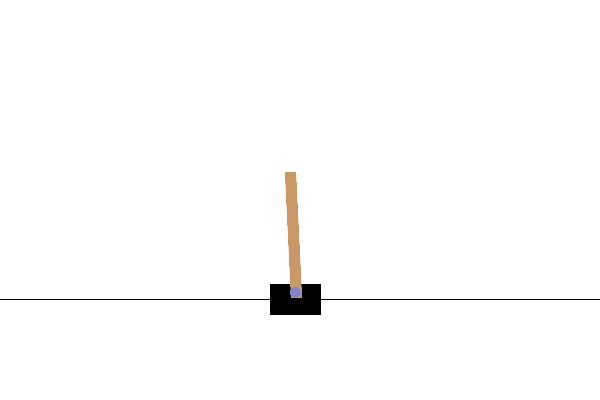

In [ ]:
from IPython.display import HTML
from base64 import b64encode
import io
from PIL import Image

def visualize_episode_colab(agent, env):
    """
    Визуализирует один эпизод игры для заданного агента в Google Colab
    Параметры:
    agent: обученный агент (матрица весов)
    env: окружение
    """


    def create_html_animation(frames):
        # Создание анимированного GIF из кадров
        with io.BytesIO() as buffer:
            Image.fromarray(frames[0]).save(
                buffer, format='GIF',
                save_all=True,
                append_images=[Image.fromarray(frame) for frame in frames[1:]],
                duration=50,
                loop=0
            )
            buffer.seek(0)
            animation = buffer.read()
        return HTML('<img src="data:image/gif;base64,%s">' % b64encode(animation).decode())

    frames = []
    observation, _ = env.reset()
    total_reward = 0

    while True:
        # Получаем кадр для визуализации
        frame = env.render()
        frames.append(frame)

        # Выбираем действие
        action = np.argmax(np.dot(agent.T, observation))

        # Выполняем действие
        observation, reward, done, truncated, _ = env.step(action)
        total_reward += reward

        if done or truncated:
            break

    print(f"Итоговая награда: {total_reward:.2f}")

    # Отображаем анимацию
    return create_html_animation(frames)

# Использование функции:
# Отобразить эпизод
ipythondisplay.display(visualize_episode_colab(test_population_Cart_Pole, env))